In [17]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers, models
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

# CNN + SVM - only train the classifier

In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'Polyp_copy/train'
validation_data_dir = 'Polyp_copy/validation'

# Image generation 
train_datagen = ImageDataGenerator(
     rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
     height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 # Image generation 

validation_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=45,
      width_shift_range=0.3,
    height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 
# set our batch size
batch_size = 25

 # Standardize image size (size of ImageNet images)
img_rows, img_cols = 224, 224 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [19]:
Pre_trained_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all layers
for layer in Pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

print()
print(len(Pre_trained_model.layers))

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool

19


In [20]:
Pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
last_layer = Pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


In [22]:
# DEFINE the Model
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='sigmoid')(x)

# Configure and compile the model

model = tf.keras.Model(Pre_trained_model.input, x)

# optimizer = Adam(learning_rate=0.001)
optimizer = SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [24]:
#Training the MODEL Feature-Extraction
# Enter the number of training and validation samples here
nb_train_samples = 300
nb_validation_samples = 100

# Train 70 EPOCHS 
epochs = 70

r = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/70


2023-03-23 23:19:36.974710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 0.8335 - acc: 0.4333

2023-03-23 23:20:00.779451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 31s 2s/step - loss: 0.8335 - acc: 0.4333 - val_loss: 0.7347 - val_acc: 0.4900
Epoch 2/70
12/12 [==============================] - 26s 2s/step - loss: 0.7800 - acc: 0.5233 - val_loss: 0.7142 - val_acc: 0.4900
Epoch 3/70
12/12 [==============================] - 27s 2s/step - loss: 0.7738 - acc: 0.4833 - val_loss: 0.7161 - val_acc: 0.5000
Epoch 4/70
12/12 [==============================] - 25s 2s/step - loss: 0.7382 - acc: 0.5267 - val_loss: 0.6932 - val_acc: 0.5800
Epoch 5/70
12/12 [==============================] - 28s 2s/step - loss: 0.7580 - acc: 0.4867 - val_loss: 0.6864 - val_acc: 0.5600
Epoch 6/70
12/12 [==============================] - 27s 2s/step - loss: 0.7445 - acc: 0.5200 - val_loss: 0.6981 - val_acc: 0.5800
Epoch 7/70
12/12 [==============================] - 29s 2s/step - loss: 0.7351 - acc: 0.5067 - val_loss: 0.6911 - val_acc: 0.5400
Epoch 8/70
12/12 [==============================] - 28s 2s/step - loss: 0.7609 - acc: 0.4667 - val_lo

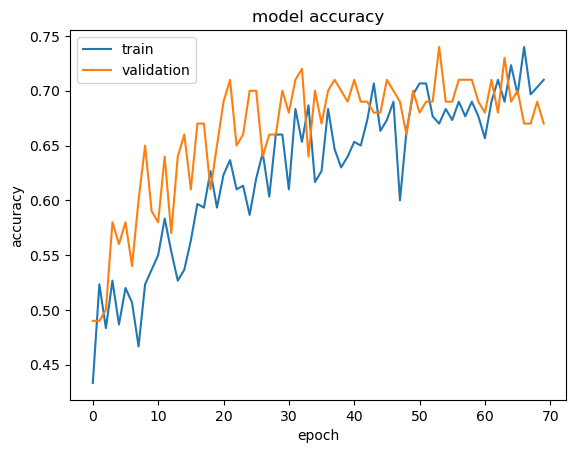

In [25]:
plt.plot(r.history['acc'])
plt.plot(r.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

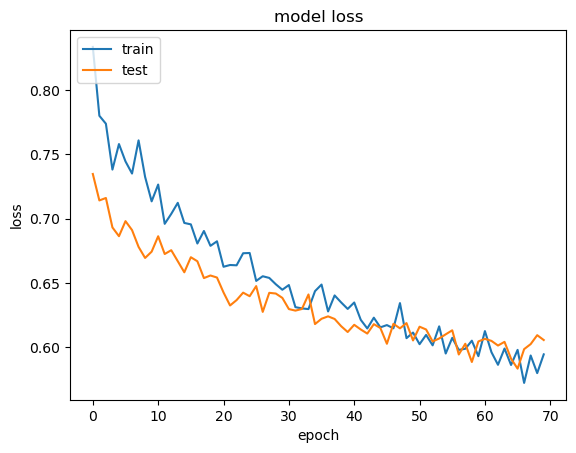

In [26]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()